In [411]:
import os
from functools import partial
from typing import (
  Tuple, List, Dict, Any, Sequence, Callable)

import jax
import jax.numpy as jnp
import jax.random as jr 
import haiku as hk
import jraph
import optax
import numpy as np
import matplotlib.pyplot as plt

from mnist_to_graphs import pad_graph_to_value

Notes:
* loss for batch of padded graphs calculated by masking out the additional padding graph, so use `.sum()` not `.mean()` for calculating loss. This is because the un-masking keeps the shape concrete meaning that there are zero entries in the batch-loss vector, that should not weight in the scalar-loss average.

#### globals

In [412]:
Array = jnp.ndarray
Graph = jraph.GraphsTuple
Params = hk.Params
Key = jr.PRNGKey

N_GRAPHS = 2000 # = n_sims
LR = 6.e-5
ACTIVATION = jax.nn.swish
BATCH_SIZE = 16
N_STEPS = 5_000
PAD_VALUE = 4096#2048 #8128 
F = 8
E = 8

#### data

In [413]:
def get_R_z_string(R_values, z_values, n_moments_calculate=3):
    if isinstance(R_values, list):
        if len(R_values) == len(all_R_values):
            R_string = "all"
        else:
            R_string = "_".join([str(float(R)) for R in R_values])
    else:
        R_string = str(R_values)
    if isinstance(z_values, list):
        if len(z_values) == len(all_redshifts):
            z_string = "all"
        else:
            z_string = "_".join([str(float(z)) for z in z_values])
    else:
        z_string = str(z_values)

    return f"x={resolution}_R={R_string}_z={z_string}_nm={n_moments_calculate}"

prng_seq = hk.PRNGSequence(0)

data_dir = "/Users/Jed.Homer/phd/lfi/jaxdelfi/data/"
resolution = 1024 
all_redshifts = [0., 0.5, 1., 2., 3.]
all_R_values = ["5.0", "10.0", "15.0", "20.0", "25.0", "30.0"]

redshifts = all_redshifts[:1]
R_values = all_R_values[:4]

R_idx = [all_R_values.index(R) for R in R_values]
z_idx = [redshifts.index(z) for z in redshifts]

print(f"Running for redshifts:\n\t{redshifts}\nat resolution x={resolution} with R values:\n\t{R_values}.")

Rz_string = get_R_z_string(R_values, redshifts, n_moments_calculate=3)

Running for redshifts:
	[0.0]
at resolution x=1024 with R values:
	['5.0', '10.0', '15.0', '20.0'].


#### data
* for each moments datavector, make fully connected subgraph for each redshift, then concatenate all the redshift graphs together...

In [414]:
alpha = jnp.array([
    0.3175, 0.049, 0.6711, 0.9624, 0.834])
parameters = jnp.load(
    os.path.join(data_dir, f"ALL_PDFS_PARAMS.npy")) 
# fiducial_dv = jnp.load(
#     os.path.join(data_dir, f'fiducial_moments_unflat_{Rz_string}.npy')).mean(axis=0)
# simulations = jnp.load(
#     os.path.join(data_dir, f"CALCULATED_PDF_MOMENTS_{Rz_string}.npy"))
simulations = jnp.load(
    os.path.join(data_dir, f"latin_pdfs_cut_{Rz_string}.npy"))
fiducial_dv = jnp.load(
    os.path.join(data_dir, f"fiducial_pdfs_cut_{Rz_string}.npy"))
fiducial_dv = fiducial_dv.mean(axis=0)[jnp.newaxis, :]

n_sims, parameter_dim = parameters.shape
data_dim = np.prod(fiducial_dv.shape)

parameters.shape, simulations.shape, fiducial_dv.shape

((2000, 5), (2000, 151), (1, 151))

In [531]:
def make_subgraphs(moments):
    # Vmapping, so this is z-axis
    all_g_z = []

    # Add scale information to nodes?
    # z_R_information = jnp.stack([R_values_float])

    for z, mz in enumerate(moments):
        # print(mz.shape, np.prod(mz.shape))
        # Only add redshifts to node features if using multi-redshifts
        n_node_per_graph = np.prod(mz.shape)
        if len(redshifts) > 1:
            z_ = jnp.asarray([redshifts[z]])
            node_features = jnp.concatenate([z_, mz.flatten()])
            n_node_per_graph += 1
        else:
            node_features = mz.flatten()
        g_z = jraph.get_fully_connected_graph(
            # Concatenate redshift information to nodes
            node_features=node_features, 
            n_node_per_graph=n_node_per_graph,
            n_graph=1,
            #global_features=parameters, # maybe just parameters for main_graph not subgraphs?
            add_self_edges=False)
        all_g_z.append(g_z)
    return all_g_z 

def make_graph_from_subgraphs(subgraphs, parameters):
    """ 
        Make ONE graph from fully connected redshift-subgraphs
        - NO connections between subgraphs of different redshift
        - Initialise global property as total cardinalities of subgraphs over all z
            -> try cardinality vector with cardinalities of subgraphs
    """
    # For each redshift, shift its sender/receiver indices by the number of nodes in the 
    # redshift subgraph, so that the senders/receivers are still unique in the main graph
    # for all subgraphs
    receivers = jnp.concatenate(
        [g_z.n_node * n + g_z.receivers for n, g_z in enumerate(subgraphs)])# receivers=jnp.concatenate([g_z.receivers for g_z in subgraphs]),
    senders = jnp.concatenate(
        [g_z.n_node * n + g_z.senders for n, g_z in enumerate(subgraphs)])# senders=jnp.concatenate([g_z.senders for g_z in subgraphs]),
    nodes = jnp.concatenate([g_z.nodes for g_z in subgraphs])[:, None]
    n_node = sum([g_z.n_node for g_z in subgraphs])
    n_edge = sum([g_z.n_edge for g_z in subgraphs])
    cardinalities = jnp.array([n_node, n_edge], dtype=jnp.float32).T#[None, :]
    # cardinalities = jnp.array([len(nodes), len(senders)], dtype=jnp.float32).T#[None, :]
    # cardinalities = jnp.log10(cardinalities)
    return jraph.GraphsTuple(
        nodes=nodes,
        edges=None, # edges=jnp.concatenate([g_z.edges for g_z in subgraphs]), # edge FEATURES not senders/receivers
        # Since graph is made of subgraphs, need to re-index S and R for main_graph indexing...
        senders=senders,
        receivers=receivers,
        # should n_node, for each graph, be shifted by the amount of nodes in graph before it?
        # e.g. in jraph.batch([5 separate graphs]) the n_nodes are of shape (5,)
        n_node=n_node,
        n_edge=n_edge,
        globals=cardinalities)#[None, :])#parameters)#jnp.zeros_like(parameters))#parameters)#[None, :] if parameters.ndim == 1 else parameters)

In [532]:
subgraphs = make_subgraphs(fiducial_dv)

subgraphs[0].senders, subgraphs[0].n_node, subgraphs[0].n_edge

/Users/Jed.Homer/miniconda3/envs/jraph/lib/python3.10/site-packages/jraph/_src/utils.py:882: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  num_node_features = jax.tree_leaves(node_features)[0].shape[0]


(DeviceArray([  1,   2,   3, ..., 147, 148, 149], dtype=int32),
 DeviceArray([151], dtype=int32),
 DeviceArray([22650], dtype=int32))

In [533]:
main_graph = make_graph_from_subgraphs(subgraphs, alpha)

print(
    "nodes", main_graph.nodes.shape, 
    "\nedges", main_graph.edges, 
    "\nglobals", main_graph.globals, 
    "\nsenders", main_graph.senders.shape, 
    "\nreceivers", main_graph.receivers.shape, 
    "\nglobals", main_graph.globals.shape)

nodes (151, 1) 
edges None 
globals [[  151. 22650.]] 
senders (22650,) 
receivers (22650,) 
globals (1, 2)


In [534]:
# This is the number of nodes in the graph (there are n_R * n_m for each of the n_z subgraphs)
main_graph.senders.max()

DeviceArray(150, dtype=int32)

In [535]:
def adjacency_matrix(sender_indices, receiver_indices, n_nodes=None):
    # Determine the number of nodes in the graph if not provided
    if n_nodes is None:
        n_nodes = max(max(sender_indices), max(receiver_indices)) + 1

    # Create an empty adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))

    # Set entries in the adjacency matrix for each edge
    for sender, receiver in zip(sender_indices, receiver_indices):
        adj_matrix[sender, receiver] = adj_matrix[receiver, sender] = 1 

    return adj_matrix

In [536]:
attrs = ["nodes", "edges", "senders", "receivers", "globals", "n_node", "n_edge"]

for a in attrs:
    val = getattr(main_graph, a)
    print(a, val.shape if val is not None else None)

nodes (151, 1)
edges None
senders (22650,)
receivers (22650,)
globals (1, 2)
n_node (1,)
n_edge (1,)


In [537]:
if 0:
    # Expect three squares on diagonal: FULLY connected subgraphs
    A = adjacency_matrix(main_graph.senders, main_graph.receivers)
    print(A)
    plt.imshow(A, cmap="gray_r")
    plt.show()

#### model

##### resnet

In [538]:
layernorm_kwargs = dict(axis=1, create_scale=True, create_offset=True)

def layernorm(x):
    return hk.LayerNorm(**layernorm_kwargs)(x)

class LinearResNet(hk.Module):
  def __init__(
    self, 
    hidden_sizes: Sequence[int],
    activation: Callable = ACTIVATION,
    activate_final: bool = False,
    dropout_rate: float = 0.1):
    super().__init__()
    self.hidden_sizes = hidden_sizes
    self.activation = activation
    self.activate_final = activate_final
    self.dropout_rate = dropout_rate
    self.use_layernorm = False

  def __call__(self, x, inference=False):
    z = x
    for f in self.hidden_sizes:
    #   h = self.activation(z)
    #   h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = layernorm(z) if self.use_layernorm else z
      h = hk.Linear(f)(h)
      if not inference:
        h = hk.dropout(hk.next_rng_key(), self.dropout_rate, h)
      h = self.activation(h)

      #h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = layernorm(h) if self.use_layernorm else h
      h = hk.Linear(f, w_init=jnp.zeros)(h)
      if not inference:
        h = hk.dropout(hk.next_rng_key(), self.dropout_rate, h)
      h = self.activation(z)

      z = z + h 
    return self.activation(z) if self.activate_final else z

##### gnn

In [539]:
def node_net_fn(x: Array, inference: bool = False):
  """ Mapping (v_i, agg(E_i), u) -> v'_i"""
  h = LinearResNet([F, F, F])(x, inference=inference)
  return h 

def global_net_fn(x: Array, inference: bool = False):
  """ Mapping (N_e, N_v) -> u """
  # This needs to take into account conditioning information e.g. z?!
  h = LinearResNet([F, F, F])(x, inference=inference)
  h = hk.Linear(parameter_dim, with_bias=False)(h)
  return h

def get_node_update_fn(inference: bool):
    net_fn_ = partial(node_net_fn, inference=inference)
    return jraph.concatenated_args(net_fn_)

def get_global_update_fn(inference: bool):
    net_fn_ = partial(global_net_fn, inference=inference)
    return jraph.concatenated_args(net_fn_)

In [540]:
def add_graphs_tuples(graphs: Graph, other_graphs: Graph) -> Graph:
  graphs = graphs._replace(
    nodes=graphs.nodes + other_graphs.nodes)
  graphs = graphs._replace(
    globals=graphs.globals + other_graphs.globals)
  graphs = graphs._replace(
    senders=graphs.senders.astype(bool),
    receivers=graphs.receivers.astype(bool))
  return graphs

In [541]:
def attention_logit_fn(
  edges: Array, 
  sender_attr: Array, 
  receiver_attr: Array, 
  global_edge_attributes: Array) -> Array:
  del edges
  x = jnp.concatenate([sender_attr, receiver_attr], axis=1)
  x = hk.Linear(1)(layernorm(x))
  return x

def attention_reduce_fn(edge_features, weights):
  return edge_features[0] * weights

In [542]:
def LayerNormLinear(x, l=E, use_layernorm=False):
  h = hk.LayerNorm(**layernorm_kwargs)(x) if use_layernorm else x
  return hk.Linear(l, with_bias=False)(h)

def net_fn(
  graph: Graph, 
  inference: bool = False, 
  n_layers: int = 1, 
  use_layernorm: bool = True,
  residual: bool = False) -> Graph:

  global_embed_dim = len(alpha) if residual else E

  embedder = jraph.GraphMapFeatures(
    embed_edge_fn=None,
    embed_node_fn=partial(
        LayerNormLinear, l=E, use_layernorm=use_layernorm), 
    embed_global_fn=partial(
        LayerNormLinear, l=5, use_layernorm=use_layernorm))

  graph = embedder(graph)

  for _ in range(n_layers):
    net = jraph.GraphNetwork(
      update_edge_fn=None,
      update_node_fn=get_node_update_fn(inference=inference),
      update_global_fn=get_global_update_fn(inference=inference))
      # attention_logit_fn=attention_logit_fn,
      # attention_reduce_fn=attention_reduce_fn)#jraph.segment_sum)
    if residual:
       graph = add_graphs_tuples(net(graph), graph)
  return graph

#### train

#### trainer functions

In [557]:
dataset_processed = []
for n in range(int(N_GRAPHS * 0.1)):
  l = parameters[n]
  print("\r", l, end="")

  # Subgraph at redshift z for moments of PDF at scales R
  g_z = make_subgraphs(simulations[n])[0]

  print((f"nodes {g_z.nodes.shape}" +
         f"\nedges {g_z.edges}" + 
         f"\nglobals {g_z.globals}" + 
         f"\nsenders {g_z.senders.shape}" + 
         f"\nreceivers {g_z.receivers.shape}"))

  # Main graph of disconnected subgraphs
  g = make_graph_from_subgraphs(g_z, l[None, :]) # pointless 'l' here it is removed later anyway...

  dataset_processed.append(dict(input_graph=g, target=l))

  print((f"nodes {g.nodes.shape}" +
         f"\nedges {g.edges}" + 
         f"\nglobals {g.globals}" + 
         f"\nsenders {g.senders.shape}" + 
         f"\nreceivers {g.receivers.shape}" +
         f"\nglobals {g.globals.shape}"))
  
  # IMPORTANT CAN NEED THIS IN DICT ABOVE FOR TARGET=L#[None, :]))

 [0.1755  0.06681 0.7737  0.8849  0.6641 ]nodes (1,)
edges None
globals None
senders (0,)
receivers (0,)


AttributeError: 'DeviceArray' object has no attribute 'n_node'

In [553]:
# Show a random graphs properties
g = dataset_processed[0]["input_graph"]
for a in attrs:
  val = getattr(g, a)
  print(a, val.shape if val is not None else None)
print(g.globals)

nodes (151, 1)
edges None
senders (0,)
receivers (0,)
globals (1, 2)
n_node (1,)
n_edge (1,)
[[151.   0.]]


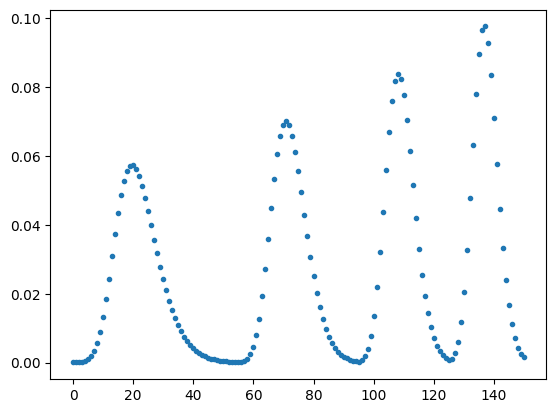

In [514]:
plt.plot(g.nodes, linestyle="", marker=".")
plt.show()

In [552]:
g.edges

In [494]:
# Make a batch of graphs to test batching
gs, ls = [], []
for _ in range(5):
  gl = dataset_processed[_]
  g, l = gl.values()
  gs.append(g), ls.append(l)

g_all = jraph.batch(gs)
print([g.nodes.shape for g in gs])
g_all.nodes.shape
print(g_all.n_node)
print(g_all.n_edge)

for a in attrs:
  val = getattr(g_all, a)
  print(a, val.shape if val is not None else None)

[(151, 1), (151, 1), (151, 1), (151, 1), (151, 1)]
[151. 151. 151. 151. 151.]
[0 0 0 0 0]
nodes (755, 1)
edges None
senders (0,)
receivers (0,)
globals (5, 2)
n_node (5,)
n_edge (5,)


In [495]:
# Set the graph globals to zero at first?
print(dataset_processed[0]["target"], dataset_processed[0]["input_graph"].globals)
len(dataset_processed)

[0.1755  0.06681 0.7737  0.8849  0.6641 ] [[2.1789768      -inf]]


200

In [496]:
jnp.ones((3, 2)) * jnp.array([True, True, False])[:, None]

DeviceArray([[1., 1.],
             [1., 1.],
             [0., 0.]], dtype=float32)

In [453]:
def compute_loss(
  params: Params, 
  key: Key,
  graph: Graph, 
  label: Array,
  net: Graph,
  inference: bool = False) -> Tuple[Array, Array]:
  pred_graph = net.apply(params, key, graph, inference=inference)
  mask = jraph.get_graph_padding_mask(pred_graph)
  print("mask", mask.shape)
  loss = jnp.square(jnp.subtract(pred_graph.globals, label)) 
  print("loss", loss.shape)
  loss = (loss * mask[:, None]).sum() / (loss.shape[0] - 1.)#.mean()
  return loss, (None,)

def get_graphs(key, dataset):
  # Randomly choose BATCH_SIZE number of (graphs, label) tuples
  idx = jr.randint(
    key, shape=(BATCH_SIZE,), minval=0, maxval=len(dataset))

  gs, ls = [], []
  for i in idx:
    g, l = dataset[int(i)].values()
    gs.append(g), ls.append(l)

  graph = jraph.batch(gs)
  graph = pad_graph_to_value(graph, PAD_VALUE)

  label = jnp.stack(ls)
  label = jnp.concatenate([label, jnp.zeros((1, parameter_dim))])
  # print("label", label)
  return graph, label

def train(
  dataset: List[Dict[str, Any]], 
  num_train_steps: int) -> Tuple[Params, List, List]:

  prng_seq = hk.PRNGSequence(0)

  net = hk.transform(net_fn)

  train_dataset = [
    dataset[t] for t in range(int(0.9 * N_GRAPHS))]
  valid_dataset = [
    dataset[-v] for v in range(int(0.1 * N_GRAPHS))]

  graph = train_dataset[0]['input_graph']
  graph = pad_graph_to_value(graph, PAD_VALUE)
  params = net.init(next(prng_seq), graph)

  print(f"n_params = {sum(x.size for x in jax.tree_util.tree_leaves(params)):.2E}")

  # Initialize the optimizer.
  opt_init, opt_update = optax.adabelief(LR)
  opt_state = opt_init(params)

  compute_loss_ = partial(compute_loss, net=net, inference=False)
  compute_loss_fn = jax.jit(
    jax.value_and_grad(compute_loss_, has_aux=True))
  eval_fn = jax.jit(partial(compute_loss, net=net, inference=True))

  train_losses, valid_losses = [], []
  for s in range(num_train_steps):

    # Train
    graph, label = get_graphs(next(prng_seq), train_dataset)
    # print("global/label", graph.globals.shape, label.shape)

    # Zero out global label, model must predict it, init'd with cardinalities so don't remove!
    # graph = graph._replace(globals=jnp.zeros_like(graph.globals))

    # graph = pad_graph_to_value(graph, PAD_VALUE)
    (train_loss, (_)), grad = compute_loss_fn(params, next(prng_seq), graph, label)

    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

    # Validate
    graph, label = get_graphs(next(prng_seq), valid_dataset)
    # print("globals", graph.globals)
    # graph = pad_graph_to_value(graph, PAD_VALUE)
    valid_loss, _ = eval_fn(params, None, graph, label)

    if s % 100 == 0:
      print(f'\rstep: {s:06d}, L: {train_loss:.4f} L_v: {valid_loss:.4f}', end="")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

  return params, train_losses, valid_losses 

#### check

In [454]:
print([_.shape for _ in g_all if _ is not None])

[(755, 1), (0,), (0,), (10,), (5,), (5,)]


In [455]:
g_all.globals.shape, g_all.globals 

((10,),
 DeviceArray([5.0172796,      -inf, 5.0172796,      -inf, 5.0172796,
                   -inf, 5.0172796,      -inf, 5.0172796,      -inf],            dtype=float32))

In [456]:
key = jr.PRNGKey(0)
key, _ = jr.split(key)

# net = hk.without_apply_rng(hk.transform(net_fn))
net = hk.transform(net_fn)

graph = pad_graph_to_value(g_all, PAD_VALUE)
print(graph.globals, graph.globals.shape)

params = net.init(key, g_all)

y_ = net.apply(params, key, g_all)
print("net out", y_.globals.shape)

mask = jraph.get_graph_padding_mask(y_)
print("mask, y_.globals", mask.shape, y_.globals.shape)

jnp.argmax(y_.globals[:, mask], axis=1), l.argmax()
# jnp.argmax(y_.globals[mask], axis=1), l.argmax()

[5.0172796      -inf 5.0172796      -inf 5.0172796      -inf 5.0172796
      -inf 5.0172796      -inf 0.       ] (11,)
net out (5,)
mask, y_.globals (5,) (5,)


IndexError: boolean index did not match shape of indexed array in index 1: got (5,), expected ()

In [ ]:
key = jr.PRNGKey(0)
key, _ = jr.split(key)

net = hk.transform(net_fn)

ix1, ix2 = jr.randint(key, (2,), 0, len(dataset_processed))

graph = dataset_processed[ix1]['input_graph']
l = dataset_processed[ix1]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print(graph.globals, graph.globals.shape)

for a in attrs:
    val = getattr(graph, a)
    print(a, val.shape if val is not None else None)

params = net.init(key, graph)

graph = dataset_processed[ix2]['input_graph']
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)

y_ = net.apply(params, key, graph)
print("net out", y_.globals.shape)

mask = jraph.get_graph_padding_mask(y_)
print("mask, y_.globals", mask.shape, y_.globals.shape)

# jnp.argmax(y_.globals[mask], axis=1), l.argmax()

[[5.710438 0.      ]
 [0.       0.      ]] (2, 2)
nodes (4097, 1)
edges None
senders (4096,)
receivers (4096,)
globals (2, 2)
n_node (2,)
n_edge (2,)
net out (2, 5)
mask, y_.globals (2,) (2, 5)


In [ ]:
graph = dataset_processed[ix2]['input_graph']
print("before pad", graph.nodes.shape, graph.globals.shape)
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print("after pad", graph.nodes.shape, graph.globals.shape)

before pad (151, 1) (1, 2)
after pad (4097, 1) (2, 2)


In [ ]:
dataset_processed[0]["target"].shape

(5,)

In [ ]:
params, train_losses, valid_losses = train(dataset_processed, num_train_steps=N_STEPS)

n_params = 2.40E+01
mask (17,)
loss (17, 5)
mask (17,)
loss (17, 5)
step: 004900, L: 0.0550 L_v: 0.046354

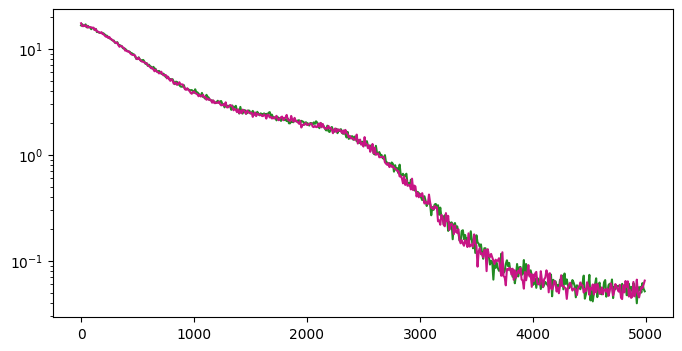

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8., 4.))
steps = range(0, N_STEPS, 10)
ax.semilogy(steps, train_losses[::10], color="forestgreen")
ax.semilogy(steps, valid_losses[::10], color="mediumvioletred")
plt.show()

In [ ]:
graphs = []
for gl in dataset_processed:
    g, l = gl.values()
    graphs.append(g)

all_graphs = jraph.batch(graphs)
for a in attrs:
    val = getattr(all_graphs, a)
    print(a, val.shape if val is not None else None)

nodes (302000, 1)
edges None
senders (0,)
receivers (0,)
globals (2000, 2)
n_node (2000,)
n_edge (2000,)


In [ ]:
fiducial_subgraphs = make_subgraphs(fiducial_dv)
fiducial_graph = make_graph_from_subgraphs(fiducial_subgraphs, alpha[None, :])

/Users/Jed.Homer/miniconda3/envs/jraph/lib/python3.10/site-packages/jraph/_src/utils.py:882: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  num_node_features = jax.tree_leaves(node_features)[0].shape[0]


In [ ]:
all_graphs_out = net.apply(params, None, all_graphs, inference=True)
fiducial_graph_out = net.apply(params, None, fiducial_graph, inference=True)
preds = all_graphs_out.globals
fiducial_preds = fiducial_graph_out.globals

fiducial_preds.shape, fiducial_preds, preds

((1, 5),
 DeviceArray([[ 0.5978021 , -0.10030725,  1.5181686 ,  1.4901392 ,
               -0.06705358]], dtype=float32),
 DeviceArray([[0.31862435, 0.05028487, 0.69140375, 0.99972016, 0.80125445],
              [0.31862435, 0.05028487, 0.69140375, 0.99972016, 0.80125445],
              [0.31862435, 0.05028487, 0.69140375, 0.99972016, 0.80125445],
              ...,
              [0.31862435, 0.05028487, 0.69140375, 0.99972016, 0.80125445],
              [0.31862435, 0.05028487, 0.69140375, 0.99972016, 0.80125445],
              [0.31862435, 0.05028487, 0.69140375, 0.99972016, 0.80125445]],            dtype=float32))

In [ ]:
# List of graphs
# unbatched_graphs = jraph.unbatch(all_graphs_out)

senders and receivers are constant through application of graph interaction network, try attention mechanism

In [ ]:
# A = adjacency_matrix(unbatched_graphs[0].senders, unbatched_graphs[0].receivers)
# plt.imshow(A, cmap="gray_r")
# plt.show()

In [ ]:
if 0:
    A = adjacency_matrix(fiducial_graph_out.senders, fiducial_graph_out.receivers)
    plt.imshow(A, cmap="gray_r")
    plt.show()

In [ ]:
# pred_targets, alpha[jnp.array([0, 4])]

(2000, 2) (2000, 2)


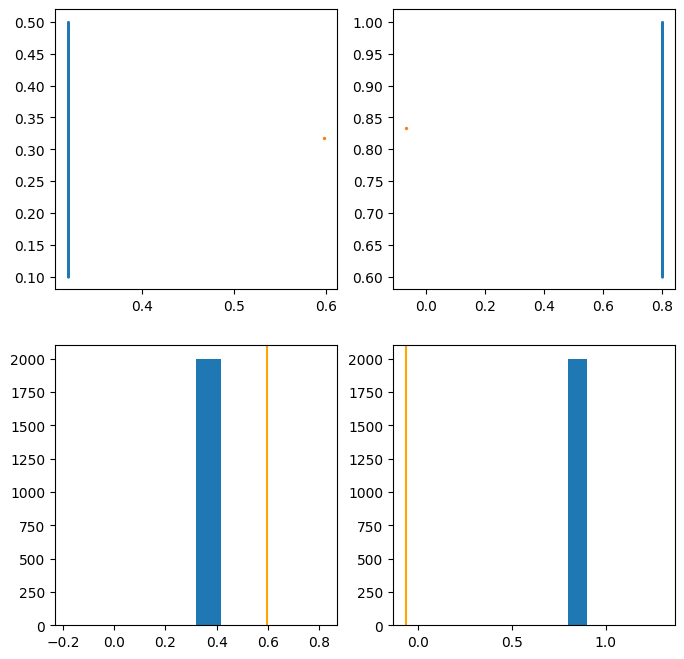

In [ ]:
target_idx = jnp.array([0, 4])
pred_targets = preds[:, target_idx]
parameter_targets = parameters[:N_GRAPHS, target_idx]

print(pred_targets.shape, parameter_targets.shape)

fig, axs = plt.subplots(2, 2, figsize=(8., 8.), dpi=100)
ax = axs[0, 0]

ax.scatter(pred_targets[:, 0], parameter_targets[:, 0], s=0.5)
ax.scatter(fiducial_preds[:, 0], alpha[None, :][:, 0], s=2.)
ax = axs[0, 1]
ax.scatter(pred_targets[:, 1], parameter_targets[:, 1], s=0.5)
ax.scatter(fiducial_preds[:, 4], alpha[None, :][:, 4], s=2.)
ax = axs[1, 0]
ax.hist(pred_targets[:, 0])
ax.axvline(fiducial_preds[:, 0], color="orange")
ax = axs[1, 1]
ax.hist(pred_targets[:, 1])
ax.axvline(fiducial_preds[:, 4], color="orange")
plt.show()

In [ ]:
fiducial_preds.shape

(1, 5)

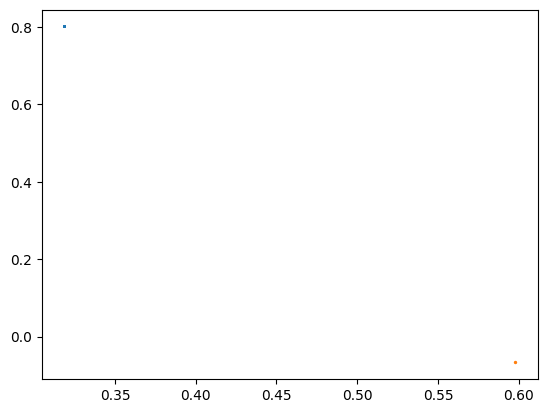

In [ ]:
plt.figure()
plt.scatter(*pred_targets.T, s=0.5)
plt.scatter(*fiducial_preds[:, target_idx].T, s=2.)
plt.show()

In [ ]:
fiducial_dv.shape

(1, 151)

In [ ]:
fiducial_dv.shape

(1, 151)

In [ ]:
# Try gnn on datavector with more or less moments

fiducial_dv_ = fiducial_dv#[:1, :2, :1]

fiducial_subgraphs_ = make_subgraphs(fiducial_dv_)
fiducial_graph_ = make_graph_from_subgraphs(fiducial_subgraphs_, alpha[None, :])

fiducial_graph_out = net.apply(params, None, fiducial_graph_, inference=True)

In [ ]:
fiducial_graph.globals, fiducial_graph_out.globals

(DeviceArray([[ 5.710438, 10.721063]], dtype=float32),
 DeviceArray([[ 0.5978021 , -0.10030725,  1.5181686 ,  1.4901392 ,
               -0.06705358]], dtype=float32))